In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png" or ".tif":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG


In [ ]:
adenosis = np.array(Dataset_loader('/content/drive/MyDrive/Datasets/BreakHIS/Benign/adenosis_group', 128))
fibroadenoma = np.array(Dataset_loader('/content/drive/MyDrive/Datasets/BreakHIS/Benign/fibroadenoma', 128))
phyllodes_tumor = np.array(Dataset_loader('/content/drive/MyDrive/Datasets/BreakHIS/Benign/phyllodes_tumor_group', 128))
tubular_adenoma = np.array(Dataset_loader('/content/drive/MyDrive/Datasets/BreakHIS/Benign/tubular_adenoma_group', 128))
ductal_carcinoma = np.array(Dataset_loader('/content/drive/MyDrive/Datasets/BreakHIS/Malignant/ductal_carcinoma_group', 128))
lobular_carcinoma = np.array(Dataset_loader('/content/drive/MyDrive/Datasets/BreakHIS/Malignant/lobular_carcinoma_group', 128))
mucinous_carcinoma = np.array(Dataset_loader('/content/drive/MyDrive/Datasets/BreakHIS/Malignant/mucinous_carcinoma_group', 128))
papillary_carcinoma = np.array(Dataset_loader('/content/drive/MyDrive/Datasets/BreakHIS/Malignant/papillary_carcinoma_group', 128))

100%|██████████| 560/560 [06:46<00:00,  1.38it/s]


In [ ]:
adenosis_label = np.zeros(len(adenosis))
fibroadenoma_label = np.ones(len(fibroadenoma))
phyllodes_tumor_label = np.ones(len(phyllodes_tumor))*2
tubular_adenoma_label = np.ones(len(tubular_adenoma))*3
ductal_carcinoma_label = np.ones(len(ductal_carcinoma))*4
lobular_carcinoma_label = np.ones(len(lobular_carcinoma))*5
mucinous_carcinoma_label = np.ones(len(mucinous_carcinoma))*6
papillary_carcinoma_label = np.ones(len(papillary_carcinoma))*7

In [ ]:
x = np.concatenate((adenosis,fibroadenoma,phyllodes_tumor,tubular_adenoma,ductal_carcinoma,lobular_carcinoma,mucinous_carcinoma,papillary_carcinoma) ,axis=0)
x=x/255
y = np.concatenate((adenosis_label,fibroadenoma_label,phyllodes_tumor_label,tubular_adenoma_label,ductal_carcinoma_label,lobular_carcinoma_label,mucinous_carcinoma_label,papillary_carcinoma_label) ,axis=0)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)

In [ ]:
s=np.arange(x_train.shape[0])
np.random.shuffle(s)
x_train=x_train[s]
y_train=y_train[s]

s=np.arange(x_test.shape[0])
np.random.shuffle(s)
x_test=x_test[s]
y_test=y_test[s]

y_train=to_categorical(y_train, num_classes=8)
y_test=to_categorical(y_test, num_classes=8)


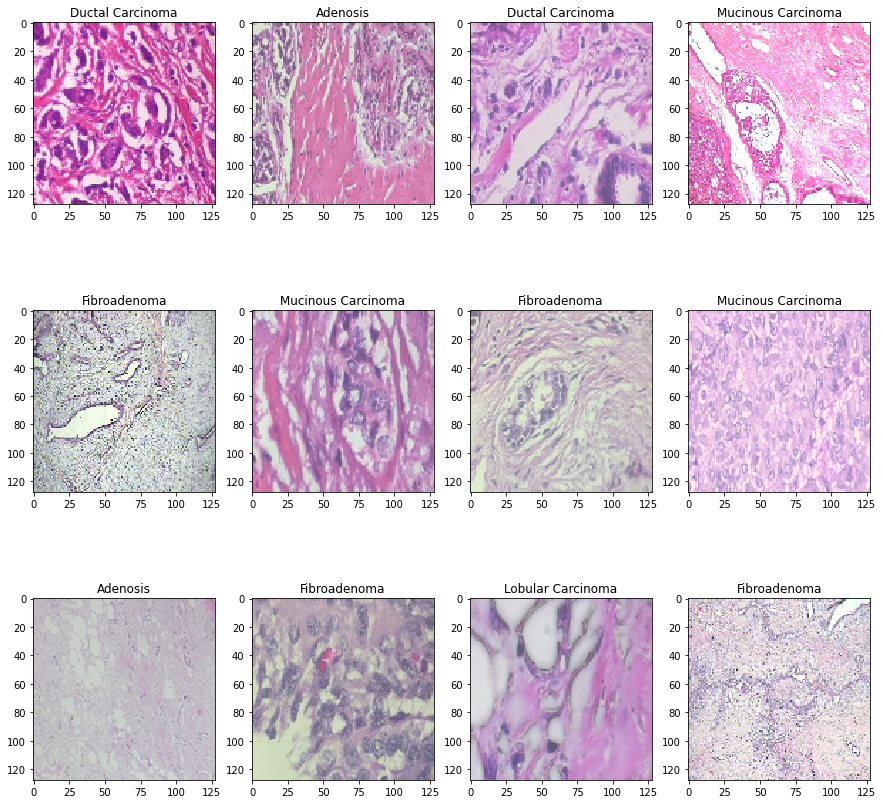

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Adenosis')
    elif np.argmax(y_train[i]) == 1:
        ax.title.set_text('Fibroadenoma')
    elif np.argmax(y_train[i]) == 2:
        ax.title.set_text('Phyllodes Tumor')
    elif np.argmax(y_train[i]) == 3:
        ax.title.set_text('Tubular Adenoma')
    elif np.argmax(y_train[i]) == 4:
        ax.title.set_text('Ductal Carcinoma')
    elif np.argmax(y_train[i]) == 5:
        ax.title.set_text('Lobular Carcinoma')
    elif np.argmax(y_train[i]) == 6:
        ax.title.set_text('Mucinous Carcinoma')    
    else:
        ax.title.set_text('Papillary Carcinoma')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 128

train_generator = ImageDataGenerator(
        zoom_range=2,  
        rotation_range = 90,
        horizontal_flip=True,
        vertical_flip=True,  
    )

In [ ]:
def build_model():
    model = Sequential()
    model.add(DenseNet201(weights='imagenet',include_top=False,input_shape=(128,128,3)))
    model.add(layers.Conv2D(1920,(4,4),padding="same",activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(480,(4,4),padding="same",activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(240,(4,4),padding="same",activation = 'relu'))
  
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())

    
    model.add(layers.Dense(8,kernel_regularizer = regularizers.l2(0.01),activation = "softmax"))
    
    
    model.compile(
        loss= "squared_hinge",
        optimizer="adam",
        metrics=['accuracy']
    )
    
    return model

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Model/types_model.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 1920)        58984320  
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 1920)        7680      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 480)         14746080  
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 480)         1920      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 240)         1843440   
_________________________________________________________________
global_average_pooling2d (Gl (None, 240)               0

In [ ]:
learn_control = ReduceLROnPlateau(monitor='accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="/content/drive/MyDrive/Model/types_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = new_model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=100,
    callbacks=[learn_control, checkpoint]
)

Epoch 1/100
42/42 [==============================] - 175s 3s/step - loss: 0.9879 - accuracy: 0.7772

Epoch 00001: accuracy improved from -inf to 0.77723, saving model to /content/drive/MyDrive/Model/types_model.h5
Epoch 2/100
42/42 [==============================] - 101s 2s/step - loss: 0.9863 - accuracy: 0.7798

Epoch 00002: accuracy improved from 0.77723 to 0.77978, saving model to /content/drive/MyDrive/Model/types_model.h5
Epoch 3/100
42/42 [==============================] - 101s 2s/step - loss: 0.9853 - accuracy: 0.7838

Epoch 00003: accuracy improved from 0.77978 to 0.78380, saving model to /content/drive/MyDrive/Model/types_model.h5
Epoch 4/100
42/42 [==============================] - 101s 2s/step - loss: 0.9870 - accuracy: 0.7767

Epoch 00004: accuracy did not improve from 0.78380
Epoch 5/100
42/42 [==============================] - 101s 2s/step - loss: 0.9830 - accuracy: 0.7862

Epoch 00005: accuracy improved from 0.78380 to 0.78617, saving model to /content/drive/MyDrive/Mode

KeyboardInterrupt: ignored

In [ ]:
Y_test_pred = new_model.predict(x_test)

In [ ]:
accuracy_score(np.argmax(y_test, axis=1), np.argmax(Y_test_pred, axis=1))

0.7922520221370796

In [ ]:
Y_pred = new_model.predict(x_test)

Confusion matrix, without normalization
[[ 108    2    7    1    1    1    1    0]
 [   2  247    9   26    5    0   11    0]
 [   9   34   83    0    8    1    0    0]
 [   0    6    3  168    3    0    0    0]
 [   0    3    6    0 1010   13    2    0]
 [   2    0    0    5   59  105    6    0]
 [   2   17    1   15   40    6  140    0]
 [   5   20    6   37  100    0   13    0]]


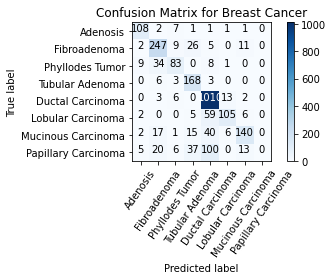

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Adenosis','Fibroadenoma','Phyllodes Tumor', 'Tubular Adenoma', 'Ductal Carcinoma', 'Lobular Carcinoma', 'Mucinous Carcinoma', 'Papillary Carcinoma' ]
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for Breast Cancer')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(Y_pred,axis=1), target_names=cm_plot_label))

                     precision    recall  f1-score   support

           Adenosis       0.84      0.89      0.87       121
       Fibroadenoma       0.75      0.82      0.79       300
    Phyllodes Tumor       0.72      0.61      0.66       135
    Tubular Adenoma       0.67      0.93      0.78       180
   Ductal Carcinoma       0.82      0.98      0.89      1034
  Lobular Carcinoma       0.83      0.59      0.69       177
 Mucinous Carcinoma       0.81      0.63      0.71       221
Papillary Carcinoma       0.00      0.00      0.00       181

           accuracy                           0.79      2349
          macro avg       0.68      0.68      0.67      2349
       weighted avg       0.73      0.79      0.76      2349



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
